### *Microlensing Statistics (Point Source - Point lens)*

A collection of code that was developed alongside Dr. Martin Makler's group of gravitational microlensing studies, focusing on reproducing Niikura's results from Niikura et. al **1701.02151**, where an exclusion limit for Primordial Black Holes as a dark matter candidate was calculated.

Unit Conventions:

$d: kpc$

$M_{PBH}: M_{\odot}$

In [2]:
import sys
sys.path.append('/mnt/c/Pessoal/CBPF/Microlensing/Microlensing/Code/Code')

In [3]:
'''
Definitions for the event rate calculation
'''

import matplotlib.pyplot as plt
import numpy as np
import mpmath as mp
from scipy.integrate import quad
from scipy.integrate import quad_vec
from scipy.integrate import dblquad
from scipy.interpolate import interp1d
from multiprocessing import Pool
from functools import partial
import astropy.constants as act
import astropy.units as aut
import sympy as sp
import math
import optical_depth_HSC as depth

kpc = act.kpc.to_value()
c = act.c.to_value()
MSun = act.M_sun.to_value()
G_num = act.G.to_value()
d = sp.Symbol('d')
d_s = sp.Symbol('d_s')
M_PBH = sp.Symbol('M_PBH')
t = sp.Symbol('t')
u_min = sp.Symbol('u_min')
u_T = sp.Symbol('u_T')
RSun=act.R_sun.to_value()

rho_c_MW = 4.88 * 10**6 * (MSun/kpc**3)
rho_c_M31 = 4.96 * 10**6 * (MSun/kpc**3)
r_s_MW = 21.5 * kpc
r_s_M31 = 25 * kpc
l = 121.2 # degree
b = -21.6 # degree
R_0 = 8.5 * kpc
d_s = 770 * kpc
hour = 3600 # seconds




# Einstein radius (d in kpc, M_PBH in MSun):

def R_E(d, M_PBH):

  return np.sqrt(((4 * G_num * M_PBH)/c**2) * (d*(1 - d/d_s)))

# NFW mass:

def M_NFW_MW(d):
  c = (depth.r_MW(d)/r_s_MW)

  func1 = (4 * np.pi * rho_c_MW * (r_s_MW)**3)
  func2 =  (np.log(1 + c) - (c/(1 + c)))

  return func1 * func2

# velocidade de dispersão:

def v_c_MW(d):
  v_c_MW = np.sqrt((G_num * M_NFW_MW(d))/depth.r_MW(d))

  return v_c_MW

# fazer a integral

def integrando_MW(d, u_min, u_T, t, M_PBH):
  v_r = ((2 * R_E(d, M_PBH) * np.sqrt(u_T**2 - u_min**2))/t)
  integrando1 = ((depth.density_DM_MW(d))/(M_PBH * v_c_MW(d)**2 ))
  integrando2 = (v_r**4/np.sqrt(u_T**2 - u_min**2))
  integrando3 = (math.exp((-v_r**2)/v_c_MW(d)**2))

  return 2*integrando1 * integrando2 * integrando3

def event_rate_MW(t, u_T, M_PBH):

    integral = dblquad(integrando_MW , 0, u_T, 0, d_s, args = (u_T, t, M_PBH,), epsabs=1.49e-03, epsrel = 5e-29)[0]

    return integral

def event_rate_paralell_MW(u_T, M_PBH, t, process=4):
    pool = Pool(process)
    ans = np.array(
        pool.map(
            partial(
                event_rate_MW,
                u_T=u_T,
                M_PBH=M_PBH,
            ),
            t,
        )
    )
    return ans

'''
Same definitions as above, but for M31
'''

def M_NFW_M31(d):
   c = (depth.r_M31(d)/r_s_M31)

   func1 = (4 * np.pi * rho_c_M31 * (r_s_M31)**3)
   func2 =  (np.log(1 + c) - (c/(1 + c)))
   return func1 * func2


def v_c_M31(d):
   v_c_M31 = np.sqrt((G_num *M_NFW_M31(d))/depth.r_M31(d))

   return v_c_M31


def integrando_M31(d, u_min, u_T, t, M_PBH):
   v_r = ((2 * R_E(d, M_PBH) * np.sqrt(u_T**2 - u_min**2))/t)
   termo1 = ((depth.density_DM_M31(d))/(M_PBH * v_c_M31(d)**2))
   termo2 = (v_r**4/np.sqrt(u_T**2 - u_min**2))
   termo3 = (math.exp((-v_r**2)/v_c_M31(d)**2))

   return 2*termo1 * termo2 * termo3

def event_rate_M31(t, u_T, M_PBH):

    integral = dblquad(integrando_M31 , 0, u_T, 0, d_s, args = (u_T, t, M_PBH,), epsabs=1.49e-03, epsrel = 5e-29)[0]

    return integral

def event_rate_paralell_M31(u_T, M_PBH, t, process=4):

    pool = Pool(process)
    ans = np.array(
        pool.map(
            partial(
                event_rate_M31,
                u_T=u_T,
                M_PBH=M_PBH,
            ),
            t,
        )
    )
    return ans

def event_rate_total(t, u_T, M_PBH):
    '''
    Total event rate from both Milky Way and M31
    '''

    event_MW = event_rate_paralell_MW(u_T, M_PBH, t, process=16)
    event_M31 = event_rate_paralell_M31(u_T, M_PBH, t, process=16)

    return event_MW + event_M31

/mnt/c/Pessoal/CBPF/Microlensing/Microlensing/Code/Code/optical_depth_HSC.py:138: RuntimeWarning: divide by zero encountered in divide
  return  (term4 / (term5 * term6))


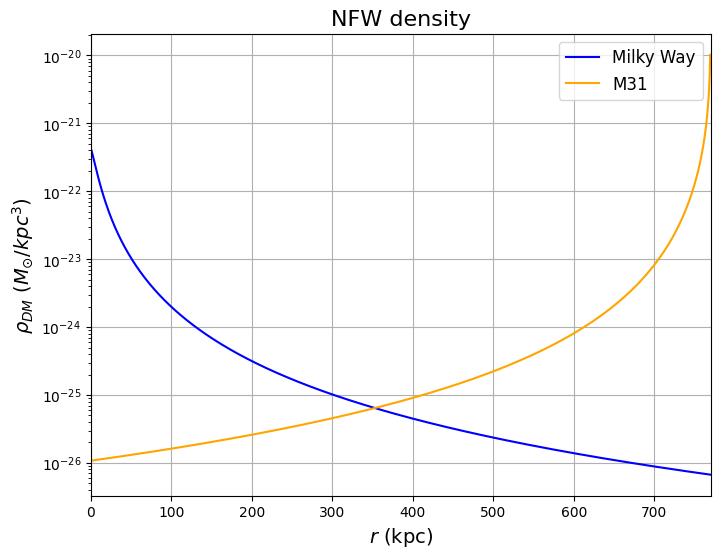

In [14]:
d1 = np.linspace(0, d_s, 1000)

plt.figure(figsize = (8, 6))

plt.plot(d1/kpc, depth.density_DM_MW(d1), label = 'Milky Way', color = 'blue')
plt.plot(d1/kpc, depth.density_DM_M31(d1), label = 'M31', color = 'orange')
plt.xlabel(r'$r$ (kpc)', fontsize = 14)
plt.ylabel(r'$\rho_{DM}$ $(M_{\odot}/kpc^{3})$', fontsize = 14)
plt.title('NFW density', fontsize = 16)

plt.yscale('log')
plt.xlim(0, d_s/kpc)
plt.legend(fontsize = 12)
plt.grid()
plt.show()


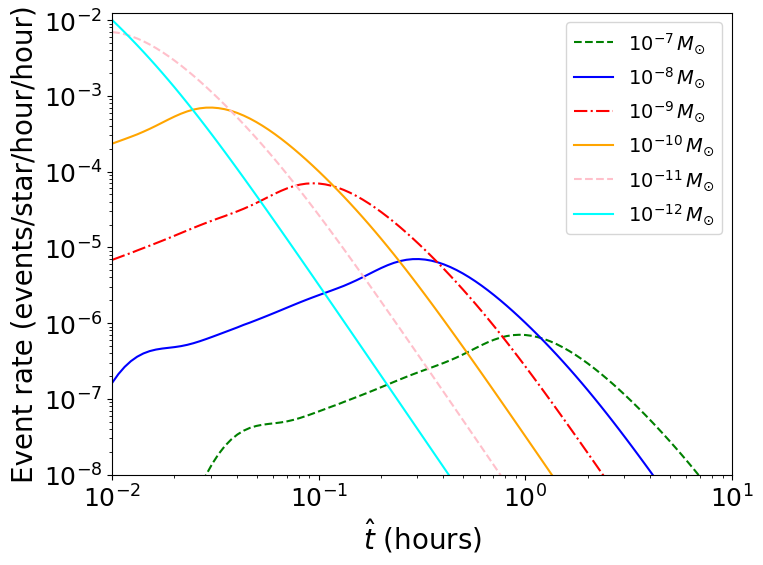

In [10]:
plt.figure(figsize = (8, 6))
t0 = np.geomspace(36, 36000, 100)

plt.loglog(t0/3600,(3600)**2 * event_rate_total(u_T=1, M_PBH=10**(-7)*MSun, t=t0), '--', color='green', label= r'$10^{-7}\, M_{\odot}$')
plt.loglog(t0/3600,(3600)**2 * event_rate_total(u_T=1, M_PBH=10**(-8)*MSun, t=t0), color='blue', label= r'$10^{-8}\, M_{\odot}$')
plt.loglog(t0/3600,(3600)**2 * event_rate_total(u_T=1, M_PBH=10**(-9)*MSun, t=t0), '-.', color='red', label= r'$10^{-9}\, M_{\odot}$')
plt.loglog(t0/3600,(3600)**2 * event_rate_total(u_T=1, M_PBH=10**(-10)*MSun, t=t0), color='orange', label= r'$10^{-10}\, M_{\odot}$')
plt.loglog(t0/3600,(3600)**2 * event_rate_total(u_T=1, M_PBH=10**(-11)*MSun, t=t0), '--', color='pink', label= r'$10^{-11}\, M_{\odot}$')
plt.loglog(t0/3600,(3600)**2 * event_rate_total(u_T=1, M_PBH=10**(-12)*MSun, t=t0), color='cyan', label= r'$10^{-12}\, M_{\odot}$')

plt.xlabel(r'$\hat{t}$ (hours)', fontsize=20)
plt.ylabel('Event rate (events/star/hour/hour)', fontsize=20)
ax = plt.gca()
ax.set_ylim([10**(-8), 10**(-1.9)])
ax.set_xlim([10**(-2), 10**(1)])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=14)
plt.show()

### ***Calculating exclusion curve***

In [3]:
''''
Extracted data from Niikura et. al 1701.02151 for efficiency calculation

OBS: Despite the time axis being in t_FWHM, we are assuming t_FWHM ~ t_hat  for simplicity and conversion complications.
'''

time_hsc = np.array([0.01674482, 0.03272845, 0.04986102, 0.07030965, 0.12940179,
       0.32728445, 0.49861024, 0.99144507, 1.48471054, 1.97140621,
       2.97769764, 3.95380208, 4.98610241, 5.97199455, 6.85205587])

efficiency_hsc = np.array([0.02820513, 0.05641026, 0.17435897, 0.47948718, 0.58205128,
       0.59230769, 0.62051282, 0.61538462, 0.61794872, 0.54615385,
       0.51282051, 0.34358974, 0.08974359, 0.02820513, 0.01538462])

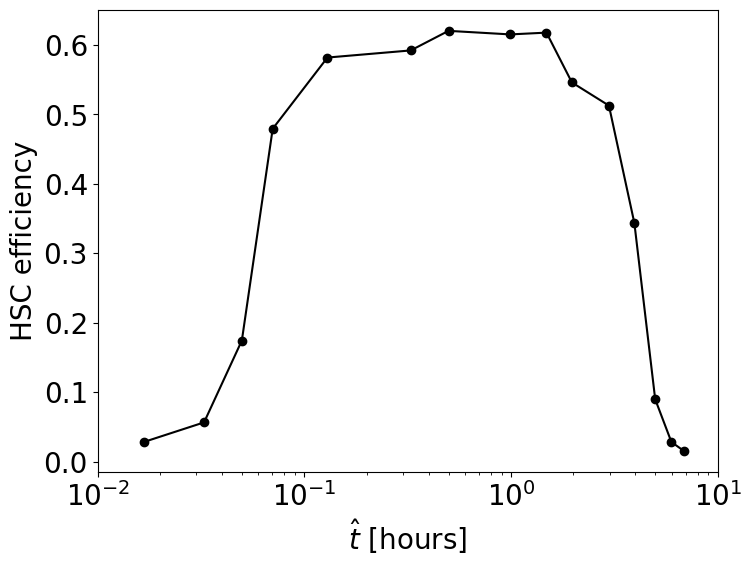

In [5]:
plt.figure(figsize = (8, 6))

plt.semilogx(time_hsc, efficiency_hsc, '-o', color='black')
plt.xlabel(r'$\hat{t}$ [hours]', fontsize=20)
plt.ylabel('HSC efficiency', fontsize=20)
plt.xlim(0.01, 10)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# plt.grid(True)
plt.show()

In [13]:
'''
Interpolation for the integration alongside event rate for the expected number of events
'''

time_secs = 3600 * time_hsc # HSC time in seconds

@np.vectorize
def new_eff(t):
  if t < time_secs.min():
    interp = 0

  elif t > time_secs.max():
    interp = 0
  
  else:
    interp = interp1d(3600 * time_hsc, efficiency_hsc, kind='linear')(t) 

  return interp

In [ ]:
'''
Non-paralellized event rate
'''

def np_total_event_rate(t, u_T, M_PBH):
  MW = event_rate_MW(t, u_T, M_PBH)
  M31 = event_rate_M31(t, u_T, M_PBH)

  return MW + M31

def n_exp_integrand(t, u_T, M_PBH):
    term1 = new_eff(t)
    term2 = np_total_event_rate(t, u_T, M_PBH)

    return term1 * term2 

E = 2.2*10**(12) # stars-seconds, converted from 7*8.7e7 stars-hours


def n_exp(M_PBH, u_T):
    integral = quad(n_exp_integrand, time_secs.min(), time_secs.max(), args=(u_T, M_PBH,), epsabs=1.49e-03, epsrel = 5e-29)[0]
    return E * integral

# Parallellized version of n_exp for f_DM calculation and computation speed

def parallel_n_exp(u_T, M_PBH, process=4):
    with Pool(process) as pool:
        ans = np.array(
            pool.map(
                partial(n_exp, u_T=u_T),
                M_PBH,
            )
        )
    return ans

In [15]:
'''
Mass range for the exclusion curve
'''

M_range = np.geomspace(1e-15, 1e-3, 100)*MSun

In [16]:
'''
Fraction of DM calculated at 95% CL
'''

f_DM = 4.74/(parallel_n_exp(u_T = 1, M_PBH = M_range, process=8)) # 95% CL

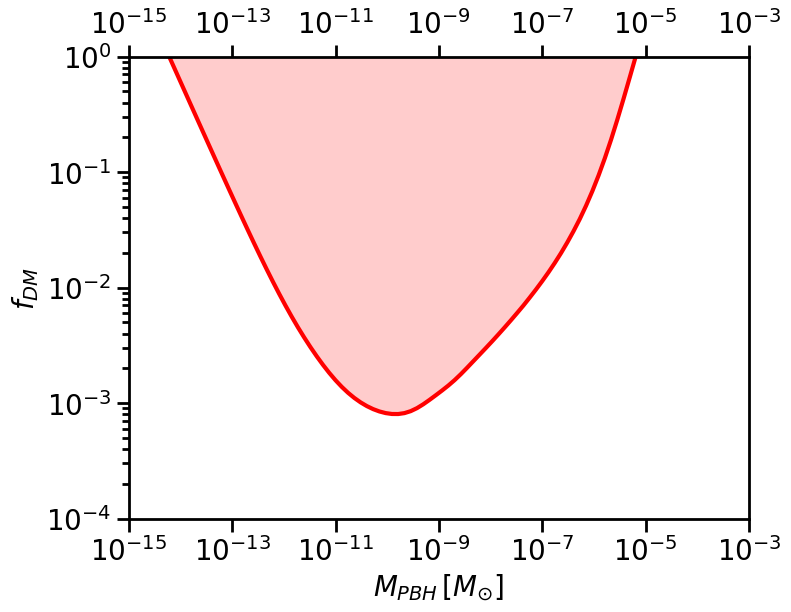

In [17]:
plt.figure(figsize=(8,6))
ax=plt.axes()

plt.loglog(M_range/MSun, f_DM, linewidth=3, color='red')
plt.ylim(1e-4,1)
plt.xlim(1e-15,1e-3)

plt.xlabel(r'$M_{PBH}\,[M_{\odot}]$', fontsize=20)
plt.ylabel(r'$f_{DM}$', fontsize=20)
plt.fill_between(M_range/MSun, f_DM, 1, facecolor='red', alpha=0.2)
plt.tick_params(top=True, labeltop=True)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=9)
ax.tick_params(which='minor', length=5, color='black')

# plt.grid(True)
